In [1]:
import os
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

In [4]:
print os.listdir("/home/beth/Desktop/Programs/patchy_polymer_with_nanocrystal/prism/work/PRISMdata/")

['Length5', 'Length4', 'Length3', 'Length7', 'Length8', 'Length10', 'Length9', 'Length6']


In [2]:
params_list = []
gr_values = []
free_energy_strings = []
base_path="/home/beth/Desktop/Programs/patchy_polymer_with_nanocrystal/prism/work/PRISMdata/"
for DLength in os.listdir(base_path):
    first_path=base_path+DLength+"/"
    for DPL in os.listdir(first_path):
        file_path=first_path+DPL+"/"
        for filename in os.listdir(file_path):
            params=re.findall(r'[0-9]*\.?[0-9]+', filename)
            full_file_path=file_path+filename
            with open(full_file_path, "r") as contents:
                textfile_values0=[]
                textfile_values1=[]
                for line in contents:
                    textfile_values0.append(line.split()[0])
                    textfile_values1.append(line.split()[1])
            if abs(float(textfile_values1[0])) < 1e-10 and textfile_values0[-1] != '(nan,':
                gr_values.append(textfile_values1[0:-1])
                free_energy_strings.append(textfile_values0[-1])
                params_list.append([float(i) for i in params])
free_energies=([float(a.strip('(),')) for a in free_energy_strings])


In [3]:
params_scaler = StandardScaler()
r_scaler = StandardScaler()

In [4]:
gr_values = np.array(gr_values)

In [5]:
r = np.arange(0.05, 7.01, 0.05)
rnorm = np.transpose(r_scaler.fit_transform( np.transpose(np.array([r]))))[0]
params_norm = params_scaler.fit_transform(params_list)

In [126]:
import dill

In [129]:
dill.dump(r_scaler, open("r_scaler.dill", "wb"))
dill.dump(params_scaler, open("params_scaler.dill", "wb"))

In [6]:
params_norm_train, params_norm_test, gr_values_train, gr_values_test = train_test_split(params_norm, gr_values,
                                                                                        test_size=0.02, random_state=42)

In [217]:
paramsfe_norm_train, paramsfe_norm_test, fe_values_train, fe_values_test = train_test_split(params_norm, free_energies,
                                                                                        test_size=0.10, random_state=32)
paramsfe_norm_train=np.array(paramsfe_norm_train)
paramsfe_norm_test=np.array(paramsfe_norm_test)
fe_values_train=np.array(fe_values_train)
fe_values_test=np.array(fe_values_test)

In [229]:
input = Input(shape=(5,))
x = Dense(256,activation='relu',kernel_initializer='orthogonal')(input)
x = Dense(256,activation='relu',kernel_initializer='orthogonal')(x)
#x = Dense(256,activation='relu',kernel_initializer='orthogonal')(x)
prediction = Dense(1,activation='linear',kernel_initializer='orthogonal')(x)
prediction = Lambda(lambda x: K.abs(x), 
                       output_shape=(1,))(prediction)
model_fe = Model(input, prediction)
model_fe.compile(optimizer='Adamax', loss='mean_squared_error')

In [230]:
model_fe.fit(paramsfe_norm_train, fe_values_train, validation_data=(paramsfe_norm_test, fe_values_test), epochs=1000, batch_size=25000, verbose=1, initial_epoch=0)

Train on 52812 samples, validate on 5868 samples
Epoch 1/1000
52812/52812 [==============================] - 2s 31us/step - loss: 0.0209 - val_loss: 0.0155
Epoch 2/1000
52812/52812 [==============================] - 2s 31us/step - loss: 0.0143 - val_loss: 0.0128
Epoch 3/1000
52812/52812 [==============================] - 2s 32us/step - loss: 0.0124 - val_loss: 0.0118
Epoch 4/1000
52812/52812 [==============================] - 2s 31us/step - loss: 0.0113 - val_loss: 0.0107
Epoch 5/1000
52812/52812 [==============================] - 2s 31us/step - loss: 0.0105 - val_loss: 0.0099
Epoch 6/1000
52812/52812 [==============================] - 2s 31us/step - loss: 0.0098 - val_loss: 0.0095
Epoch 7/1000
52812/52812 [==============================] - 2s 31us/step - loss: 0.0092 - val_loss: 0.0088
Epoch 8/1000
52812/52812 [==============================] - 2s 31us/step - loss: 0.0086 - val_loss: 0.0084
Epoch 9/1000
52812/52812 [==============================] - 2s 31us/step - loss: 0.0082 - val_l

In [236]:
model_fe.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 5)                 0         
_________________________________________________________________
dense_559 (Dense)            (None, 256)               1536      
_________________________________________________________________
dense_560 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_561 (Dense)            (None, 1)                 257       
_________________________________________________________________
lambda_297 (Lambda)          (None, 1)                 0         
Total params: 67,585
Trainable params: 67,585
Non-trainable params: 0
_________________________________________________________________


In [248]:
ick=125
print params_list[ick]
print params_norm[ick]
print model_fe.predict(np.array([np.array(params_norm[ick])])) #length, PL, diameter ratio, vol frac, gamma
print free_energies[ick]
print len(params_list)

[5.0, 2.0, 4.0, 0.25, 12.0]
[-0.70847558 -0.62848808 -0.9951042   0.24863445  2.23695691]
[[ 1.12399852]]
1.14763557013
58680


In [231]:
sorted_data=np.zeros((len(params_list), 7))
for ic in range(0, len(free_energies)):
    for j in range(0, 5):
        sorted_data[ic][j]=params_list[ic][j]
    sorted_data[ic][5]=free_energies[ic]
    sorted_data[ic][6]=model_fe.predict(np.array([np.array(params_norm[ic])]))[0][0]

In [232]:
#print sorted_data[sorted_data[:,0].argsort()]
ind = np.lexsort((sorted_data[:,4],sorted_data[:,3],sorted_data[:,2],sorted_data[:,1],sorted_data[:,0]))
sorted_data=sorted_data[ind]

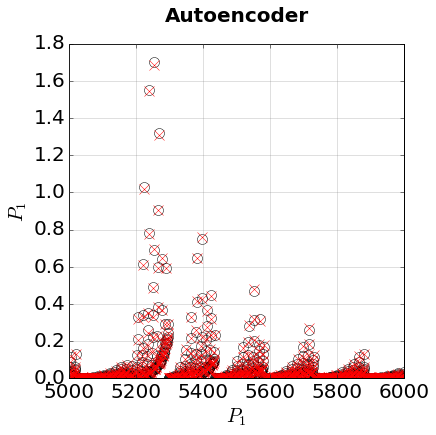

In [242]:
colors = 200*['green', 'purple', 'orange', 'teal', 'red', 'brown', 'yellow', 'blue', 'purple', 'cyan']

mnind=5000
mxind=6000
plt.plot(range(mnind,mxind), sorted_data[mnind:mxind,5], marker='o', linewidth=0.0, markersize=10, color = 'black', alpha=1.0, markerfacecolor='None')
plt.plot(range(mnind,mxind), sorted_data[mnind:mxind,6], marker='x', linewidth=0.0, markersize=10, color = 'red', alpha=1.0, markerfacecolor='None') 

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#plt.yscale('log')
#plt.ylim(0.8,0.88)

plt.xlabel(r'$P_{1}$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$P_{1}$', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('Autoencoder', y=1.05, fontdict = title_font)

plt.show()

In [246]:
model_fe_json = model_fe.to_json()
with open("model_fe.json", "w") as json_file:
    json_file.write(model_fe_json)
model_fe.save_weights('model_fe.h5')

In [9]:
functional_helper = FunctionalFitHelper()

In [10]:
print len(params_norm)
print len(gr_values)

58680
58680


In [11]:
print len(params_norm_train)
print len(params_norm_test)

57506
1174


In [402]:
#functional_helper.InitializeNewModel(5, num_cnts=10, hidden_dim=50, activation='relu')

In [459]:
#model_awesome = model
#functional_helper.InitializeNewModel(5, num_cnts=20, hidden_dim=10, activation='relu')

In [505]:
functional_helper.InitializeNewModel(5, num_cnts=50, hidden_dim=30, activation='relu')

In [51]:
functional_helper.InitializeNewModel(5, num_cnts=35, 
                           hidden_dim_rbf=25, activation_rbf='relu', 
                           hidden_dim_mod=500, activation_mod='relu')

In [52]:
model = functional_helper.BuildModel(rnorm)
model.compile(loss='mean_squared_error', optimizer='adamax')

In [53]:
history = model.fit(params_norm, np.array(gr_values), 
                    epochs=1000, 
                    verbose=1, 
                    batch_size=2000, 
                    validation_data=(params_norm_test, gr_values_test))

Train on 58680 samples, validate on 1174 samples
Epoch 1/1000
58680/58680 [==============================] - 173s 3ms/step - loss: 0.1754 - val_loss: 0.0963
Epoch 2/1000
58680/58680 [==============================] - 174s 3ms/step - loss: 0.0793 - val_loss: 0.0702
Epoch 3/1000
58680/58680 [==============================] - 174s 3ms/step - loss: 0.0628 - val_loss: 0.0580
Epoch 4/1000
58680/58680 [==============================] - 173s 3ms/step - loss: 0.0521 - val_loss: 0.0480
Epoch 5/1000
58680/58680 [==============================] - 173s 3ms/step - loss: 0.0428 - val_loss: 0.0388
Epoch 6/1000
58680/58680 [==============================] - 173s 3ms/step - loss: 0.0343 - val_loss: 0.0303
Epoch 7/1000
58680/58680 [==============================] - 172s 3ms/step - loss: 0.0265 - val_loss: 0.0231
Epoch 8/1000
58680/58680 [==============================] - 173s 3ms/step - loss: 0.0203 - val_loss: 0.0177
Epoch 9/1000
58680/58680 [==============================] - 173s 3ms/step - loss: 0.015

KeyboardInterrupt: 

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
%matplotlib inline 

In [ ]:
i = 0
params_norm_sample = params_norm[i]
gr_values_e = gr_values[i]
gr_values_p = model.predict(np.array([params_norm_sample]))[0]

In [130]:
i = 316
params_norm_sample = params_norm_test[i]
print params_norm_sample
gr_values_e = gr_values_test[i]
gr_values_p = model.predict(np.array([params_norm_sample]))[0]

[-0.70847558 -0.44129471  0.19837407  0.99963276 -0.72520597]


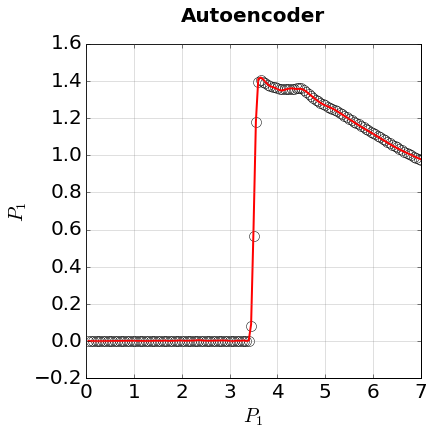

In [113]:
#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'red', 'brown', 'yellow', 'blue', 'purple', 'cyan']

plt.plot(r, gr_values_e, marker='o', linewidth=0.0, markersize=10, color = 'black', alpha=1.0, markerfacecolor='None')
plt.plot(r, gr_values_p, marker='o', linewidth=2.0, markersize=0, color = 'red', alpha=1.0, markerfacecolor='None') 

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#plt.yscale('log')
#plt.ylim(0.8,0.88)

plt.xlabel(r'$P_{1}$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$P_{1}$', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('Autoencoder', y=1.05, fontdict = title_font)

plt.show()

In [116]:
from keras.models import model_from_json

In [122]:
model_cnts = model.get_layer('model_cnts')
model_cnts_json = model_cnts.to_json()
model_efas = model.get_layer('model_efas')
model_efas_json = model_efas.to_json()
model_amps = model.get_layer('model_amps')
model_amps_json = model_amps.to_json()
model_rbfs = model.get_layer('model_rbfs')
model_rbfs_json = model_rbfs.to_json()

In [123]:
with open("model_cnts.json", "w") as json_file:
    json_file.write(model_cnts_json)
with open("model_efas.json", "w") as json_file:
    json_file.write(model_efas_json)
with open("model_amps.json", "w") as json_file:
    json_file.write(model_amps_json)
with open("model_rbfs.json", "w") as json_file:
    json_file.write(model_rbfs_json)

In [125]:
model_cnts.save_weights('model_cnts.h5')
model_efas.save_weights('model_efas.h5')
model_amps.save_weights('model_amps.h5')
model_rbfs.save_weights('model_rbfs.h5')

In [244]:
model_rbfs.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 35)                0         
_________________________________________________________________
dense_547 (Dense)            (None, 500)               18000     
_________________________________________________________________
dense_548 (Dense)            (None, 1)                 501       
Total params: 18,501
Trainable params: 18,501
Non-trainable params: 0
_________________________________________________________________


In [120]:
#model_backup = model

In [8]:
from keras import backend as K
from keras.layers import Input, Dense, Lambda, concatenate
from keras.models import Model
import numpy as np

class FunctionalFitHelper:

    def InitializeNewModel(self, x_dim, num_cnts, 
                           hidden_dim_rbf, activation_rbf, 
                           hidden_dim_mod, activation_mod):
        
        #initialization details
        self.num_cnts = num_cnts
        self.x_dim = int(x_dim)
        input = Input(shape=(self.x_dim,)) 

        #create a single layer NN for the centers, amplitudes
        #and the exponential factors
        cnt_nns = []
        for i in range(self.num_cnts):
            cnt = Dense(hidden_dim_rbf, activation=activation_rbf)(input)
            cnt = Dense(1, activation='linear')(cnt)
            cnt_nns.append(cnt)

        amp_nns = []
        for i in range(self.num_cnts):
            amp = Dense(hidden_dim_rbf, activation=activation_rbf)(input)
            amp = Dense(1, activation='linear')(amp)
            amp_nns.append(amp)

        efa_nns = []
        for i in range(self.num_cnts):
            efa = Dense(hidden_dim_rbf, activation=activation_rbf)(input)
            efa = Dense(1, activation='linear')(efa)
            efa_nns.append(efa)

        #concatenate the amplitudes and standard deviations
        if num_cnts == 1:
            cnts = cnt_nns[0]
            amps = amp_nns[0]
            efas = efa_nns[0]
        else:
            cnts = concatenate(cnt_nns, axis=-1)
            amps = concatenate(amp_nns, axis=-1)
            efas = concatenate(efa_nns, axis=-1)
            
        #model for each NN for easy access in checkpoint
        self.model_cnts = Model(input, cnts, name='model_cnts')
        self.model_amps = Model(input, amps, name='model_amps')
        self.model_efas = Model(input, efas, name='model_efas')
            
        #create a single layer NN to combine the signals
        #from the various radial basis functions before the final output
        input = Input(shape=(self.num_cnts,))
        rbfs = Dense(hidden_dim_mod, activation=activation_mod)(input)
        rbfs = Dense(1, activation='linear')(rbfs)
        
        #model for the final NN, also for checkpointing
        self.model_rbfs = Model(input, rbfs, name='model_rbfs')

        return None
    
    def InitializeOldModel(self, model):

        #get stored input dimenions
        self.x_dim = self.model_cnts.layers[0].input_shape[1]

        #get the various NNs
        self.model_cnts = model.get_layer('model_cnts')
        self.model_amps = model.get_layer('model_amps')
        self.model_efas = model.get_layer('model_efas')
        self.model_rbfs = model.get_layer('model_rbfs')

        return None
    
    def BuildModel(self, rs):
        #extract relevant dimensions 
        input = Input(shape=(self.x_dim,))

        #input rs
        rs_ = K.variable(value=np.array([rs]))
        rs_ = K.repeat_elements(rs_, rep=self.num_cnts, axis=0)
        num_rs = len(rs)

        #centers, amplitude, and exponential factor NNs
        cnts = self.model_cnts(input)
        amps = self.model_amps(input)
        efas = self.model_efas(input)

        #centers
        cnts_ = Lambda(lambda x: K.expand_dims(x, axis=2), 
                       output_shape=(self.num_cnts,1,))(cnts)
        cnts_ = Lambda(lambda x: K.repeat_elements(x, rep=num_rs, axis=2), 
                       output_shape=(self.num_cnts,num_rs,))(cnts_)

        #amplitudes
        amps_ = Lambda(lambda x: K.expand_dims(x, axis=2), 
                       output_shape=(self.num_cnts,1,))(amps)
        amps_ = Lambda(lambda x: K.repeat_elements(x, rep=num_rs, axis=2), 
                       output_shape=(self.num_cnts,num_rs,))(amps_)

        #exponential factors
        efas_ = Lambda(lambda x: K.expand_dims(x, axis=2), 
                       output_shape=(self.num_cnts,1,))(efas)
        efas_ = Lambda(lambda x: K.repeat_elements(x, rep=num_rs, axis=2), 
                       output_shape=(self.num_cnts,num_rs,))(efas_)

        #custom function implementing the radial basis functions
        def rbfs(rs, input):
            cnts = input[0]
            amps = input[1]
            efas = input[2]
            return K.abs(amps)*K.exp(-K.abs(efas)*K.pow(rs-cnts, 2))

        #rbfs wrapped in a lambda layer
        rbfs = Lambda(lambda x: rbfs(rs_, x), name='rbfs', 
                        output_shape=(num_rs,))([cnts_, amps_, efas_])
        

        #custom function to extract the RBF signal data at a single r and flatten
        def ExtractRBFActsAndFlatten(i, input):
            return K.squeeze(input[:,:,i:i+1], axis=2)

        #extract the set of RBF activities for a given r in a flattened form (as row entries)
        rbfs_all = []
        for i in range(num_rs):
            rbfs_single = Lambda(lambda x: ExtractRBFActsAndFlatten(i, x), 
                                         output_shape=(self.num_cnts,))(rbfs) 
            rbfs_all.append(rbfs_single)

        #run each set through the final RBF NN
        rbfs_all_mod = []
        for rbfs_single in rbfs_all:
            rbfs_all_mod.append(self.model_rbfs(rbfs_single))

        #concatenate everything
        output = concatenate(rbfs_all_mod, axis=-1)

        #create the model and return
        return Model(input, output)   

Using Theano backend.
